In [42]:
from pymongo import MongoClient
import pprint

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup

import json


In [43]:
#Connect to hosted MongoDB instance
client = MongoClient()
#Access already existing database
db = client['capstone2_bluenile']
#Access already existing collection in database
diamond_info = db['diamond_info']

## Parsing one page first to get workflow before iterating through all pages

In [4]:
diamonds = diamond_info.find_one({'page':1})['html']
soup = BeautifulSoup(diamonds,'html.parser')

example = []
#getting list of shapes
for i in range(len(soup.find_all('div','shape-cell-wrapper'))):
    example_diamonds = dict()
    #getting diamond shape
    example_diamonds['shape'] = soup.find_all('div','shape-cell-wrapper')[i].text
    #getting diamond price - some were discounted
    if len(soup.find_all('div','row-cell price')[i].text.split('Now: ')) == 2:
        example_diamonds['original_price'] = soup.find_all('div','row-cell price')[i].text.split('Now: ')[0][5:]
        example_diamonds['discounted_price'] = soup.find_all('div','row-cell price')[i].text.split('Now: ')[1]
    else: 
        example_diamonds['original_price'] = soup.find_all('div','row-cell price')[i].text
        example_diamonds['discounted_price'] = np.nan
    #getting diamond carat
    example_diamonds['carat'] = soup.find_all('div','row-cell carat')[i].text
    #getting diamond cut
    #repeats the cut 2x with no space in between - need to cut string in half
    x = int(len(soup.find_all('div','row-cell cut')[i].text)/2)
    example_diamonds['cut'] = soup.find_all('div','row-cell cut')[i].text[x:]
    #getting diamond color
    example_diamonds['color'] = soup.find_all('div','row-cell color')[i].text
    #getting diamond clarity
    example_diamonds['clarity'] = soup.find_all('div','row-cell clarity')[i].text
    #getting diamond polish
    example_diamonds['polish'] = soup.find_all('div','row-cell polish')[i].text
    #getting diamond symmetry
    example_diamonds['symmetry'] = soup.find_all('div','row-cell symmetry')[i].text
    #getting diamond fluorescence
    example_diamonds['fluorescence'] = soup.find_all('div','row-cell fluorescence')[i].text
    #getting diamond depth
    example_diamonds['depth'] = soup.find_all('div','row-cell depth')[i].text
    #getting diamond table
    example_diamonds['table'] = soup.find_all('div','row-cell table')[i].text
    #getting diamond lw ratio
    example_diamonds['lxwratio'] = soup.find_all('div','row-cell lxwratio')[i].text
    #getting diamond culet
    example_diamonds['culet'] = soup.find_all('div','row-cell culet')[i].text
    example.append(example_diamonds)
example

[{'shape': 'Oval',
  'original_price': '$209',
  'discounted_price': nan,
  'carat': '0.31',
  'cut': 'Very Good',
  'color': 'J',
  'clarity': 'SI1',
  'polish': 'Very Good',
  'symmetry': 'Very Good',
  'fluorescence': 'None',
  'depth': '61.7',
  'table': '58.0',
  'lxwratio': '1.44',
  'culet': 'None'},
 {'shape': 'Emerald',
  'original_price': '$240',
  'discounted_price': '$214',
  'carat': '0.30',
  'cut': 'Very Good',
  'color': 'K',
  'clarity': 'SI1',
  'polish': 'Excellent',
  'symmetry': 'Good',
  'fluorescence': 'None',
  'depth': '66.2',
  'table': '65.0',
  'lxwratio': '1.56',
  'culet': 'None'},
 {'shape': 'Emerald',
  'original_price': '$215',
  'discounted_price': nan,
  'carat': '0.30',
  'cut': 'Very Good',
  'color': 'K',
  'clarity': 'VS1',
  'polish': 'Very Good',
  'symmetry': 'Good',
  'fluorescence': 'Strong',
  'depth': '64.1',
  'table': '66.0',
  'lxwratio': '1.36',
  'culet': 'None'},
 {'shape': 'Emerald',
  'original_price': '$234',
  'discounted_price': 

## Iterate through all pages and parse to dataframe

In [44]:
def parse_to_df(num_pages):
    diamond_list = []
    for i in range(1,num_pages+1):
        diamonds = diamond_info.find_one({'page':i})['html']
        soup = BeautifulSoup(diamonds,'html.parser')


        for i in range(len(soup.find_all('div','shape-cell-wrapper'))):
            per_diamond = dict()
            per_diamond['shape'] = soup.find_all('div','shape-cell-wrapper')[i].text
            if len(soup.find_all('div','row-cell price')[i].text.split('Now: ')) == 2:
                per_diamond['original_price'] = soup.find_all('div','row-cell price')[i].text.split('Now: ')[0][5:]
                per_diamond['discounted_price'] = soup.find_all('div','row-cell price')[i].text.split('Now: ')[1]
            else: 
                per_diamond['original_price'] = soup.find_all('div','row-cell price')[i].text
                per_diamond['discounted_price'] = np.nan
            per_diamond['carat'] = soup.find_all('div','row-cell carat')[i].text
            x = int(len(soup.find_all('div','row-cell cut')[i].text)/2)
            per_diamond['cut'] = soup.find_all('div','row-cell cut')[i].text[x:]
            per_diamond['color'] = soup.find_all('div','row-cell color')[i].text
            per_diamond['clarity'] = soup.find_all('div','row-cell clarity')[i].text
            per_diamond['polish'] = soup.find_all('div','row-cell polish')[i].text
            per_diamond['symmetry'] = soup.find_all('div','row-cell symmetry')[i].text
            per_diamond['fluorescence'] = soup.find_all('div','row-cell fluorescence')[i].text
            per_diamond['depth'] = soup.find_all('div','row-cell depth')[i].text
            per_diamond['table'] = soup.find_all('div','row-cell table')[i].text
            per_diamond['lxwratio'] = soup.find_all('div','row-cell lxwratio')[i].text
            per_diamond['culet'] = soup.find_all('div','row-cell culet')[i].text
            diamond_list.append(per_diamond)
        df = pd.DataFrame(diamond_list)
    return df

In [27]:
num_pages = diamond_info.count()
num_pages

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: count is deprecated. Use estimated_document_count or count_documents instead. Please note that $where must be replaced by $expr, $near must be replaced by $geoWithin with $center, and $nearSphere must be replaced by $geoWithin with $centerSphere
  """Entry point for launching an IPython kernel.


2492

In [28]:
diamond_data = parse_to_df(num_pages)
diamond_data.to_csv(r'/Users/winglau/Desktop/Docker/Capstone2/diamond_data.csv')

In [79]:
df = pd.read_csv('/Users/winglau/Desktop/Docker/Capstone2/diamond_data.csv')

In [102]:
df.original_price = pd.to_numeric(df.original_price)

In [103]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1008 entries, 0 to 1007
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        1008 non-null   int64  
 1   shape             1008 non-null   object 
 2   original_price    1008 non-null   int64  
 3   discounted_price  237 non-null    object 
 4   carat             1008 non-null   float64
 5   cut               1008 non-null   object 
 6   color             1008 non-null   object 
 7   clarity           1008 non-null   object 
 8   polish            1008 non-null   object 
 9   symmetry          1008 non-null   object 
 10  fluorescence      1008 non-null   object 
 11  depth             1008 non-null   float64
 12  table             1008 non-null   float64
 13  lxwratio          1008 non-null   float64
 14  culet             1008 non-null   object 
 15  origina_price     0 non-null      object 
dtypes: float64(4), int64(2), object(10)
memory

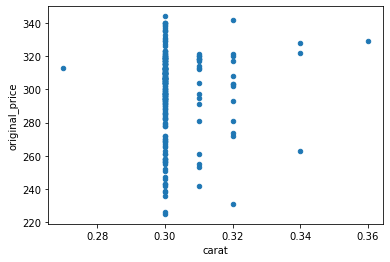

In [136]:
df[df['shape']=='Pear'].plot.scatter(x = "carat", y = "original_price")
plt.show()

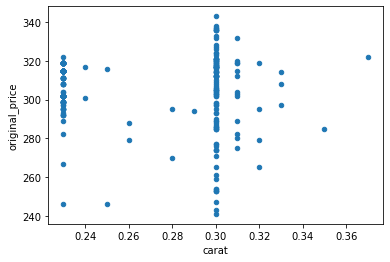

In [137]:
df[df['shape']=='Princess'].plot.scatter(x = "carat", y = "original_price")
plt.show()

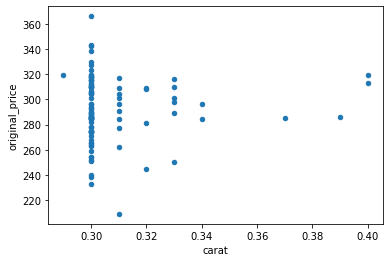

In [138]:
df[df['shape']=='Oval'].plot.scatter(x = "carat", y = "original_price")
plt.show()

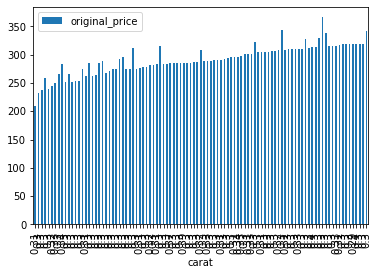

In [139]:
df[df['shape']=='Oval'].plot(x = "carat", y = "original_price",kind='bar')
plt.show()